In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [24]:
ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)
ratings.head()

,user,item,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [25]:
items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['movieId', 'title', 'genre'], header=0)
items.head()

,movieId,title,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [51]:
new = items['genre'].str.split("|", n = 1, expand = True)
#new = data["Name"].str.split(" ", n = 1, expand = True) 


AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [46]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [5]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [12]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

test _reccomend
test _reccomend
test _reccomend
test _reccomend
test _reccomend
test _reccomend
test _reccomend
test _reccomend
test _reccomend
test _reccomend


In [13]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,4095,5.483858,9,1,ItemItem
1,3171,5.405901,9,2,ItemItem
2,104283,5.400617,9,3,ItemItem
3,3792,5.371353,9,4,ItemItem
4,2563,5.362912,9,5,ItemItem


In [14]:
test_data = pd.concat(test_data, ignore_index=True)

In [15]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


ndcg
user Algorithm          
1    ALS        0.000000
     ItemItem   0.000000
2    ALS        0.051305
     ItemItem   0.000000
3    ALS        0.026762

In [16]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.065579
ItemItem    0.004820
Name: ndcg, dtype: float64

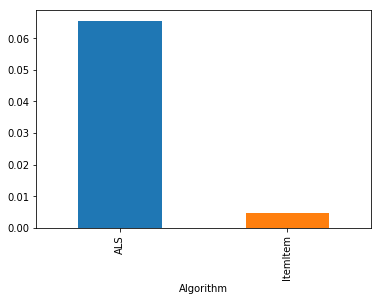

In [17]:
results.groupby('Algorithm').ndcg.mean().plot.bar()